<div class="alert alert-info">

<b>Сегодня</b>
    
<b>Программа семинара № 19: </b>
    
Процесс авторегрессии AR(p).
Временные ряды в python.
Кросс-валидация для временных рядов в python.
SARIMA-модель, остационаривание.
Гипотезы о стационарности.
Проверка стационарности в python.
Auto-SARIMA модель в python.

<div class="alert alert-info">
    
<b>Программа семинара № 20: </b>
    
TBATS, тригонометрическая сезонность.
Векторные модели временных рядов.
Кластеризация временных рядов.
Классификация на основе временных рядов.
Делаем признаки на основе рядов в python.

<center>
<img src="https://www.programmersought.com/images/582/df29336a99c8ff0304e4b55466f7f496.JPEG" height="200" width="750"> 
</center>



#  Временные ряды: SARIMA

В этой тетрадке мы продолжим знакомиться с моделями для прогнозирования временных рядов и поговорим про SARIMA. 

<center>
<img src="https://miro.medium.com/max/1400/1*yxe5Sf5JSAROq-UVgMLtmA.png" height="200" width="650"> 
</center>


SARIMA - метод прогнозирования одномерных данных временных рядов.
 
* **S** - Сезонное
* **AR** - Авторегрессионное
* **I** - интегрированное 
* **MA** - скользящее среднее


Как следует из названия, он поддерживает элементы как авторегрессии, так и скользящего среднего. Интегрированный элемент относится к разности, позволяя методу поддерживать данные временных рядов с трендом.

Проблема с ARIMA в том, что она не поддерживает сезонные данные. Это временной ряд с повторяющимся циклом.

ARIMA ожидает данных, которые либо не являются сезонными, либо в них удален сезонный компонент, например с учетом сезонных колебаний с помощью таких методов, как сезонная разность.

# Параметры

**Элементы тренда**

Есть три элемента тенденции, которые требуют настройки.

Они такие же, как модель ARIMA; конкретно:

* p: Порядок авторегрессии тренда.
* d: Порядок разницы трендов.
* q: Порядок скользящего среднего тренда.

**Сезонные элементы**

Необходимо настроить четыре сезонных элемента, которые не являются частью ARIMA; они есть:

* P: Сезонный авторегрессионный порядок.
* D: порядок сезонной разницы.
* Q: Порядок сезонной скользящей средней.
* m: количество временных шагов для одного сезонного периода.

Другими словами:

* p и сезонный P: количество авторегрессионных членов (лагов стационарного ряда)
* d и сезонный D: разность, которая должна быть сделана для стабилизации ряда
* q и сезонный Q: количество условий скользящего среднего (запаздывания ошибок прогноза)
* m: указывает продолжительность сезона в данных

In [9]:
import numpy as np
import pandas as pd

from scipy import stats 
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import seaborn as sns

%matplotlib inline

In [10]:
import warnings 
warnings.filterwarnings('ignore')

In [11]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Тест на стационарность

Чтобы бороться с нестационарностью, нужно знать её в лицо. Для этого обратимся к белому шуму и случайному блужданию, чтобы выяснить как попасть из одного в другое. Попробуем сгенерировать несколько авторегрессий и проверить гипотезу о их стационарности: $y_t = \beta y_{t-1} + u_t$ 

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss

def plotProcess(n_samples=1000, beta=0):
    y = u = np.random.normal(size=n_samples)
    for t in range(n_samples):
        y[t] = beta * y[t-1] + u[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(y)
        p_adf = round(adfuller(y)[1], 3)
        p_kpss = round(kpss(y)[1], 3)
        plt.title(f"Beta: {beta}\n Dickey-Fuller p-value: {p_adf} \n KPSS p-value: {p_kpss}")

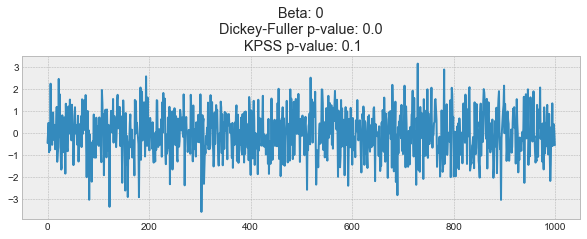

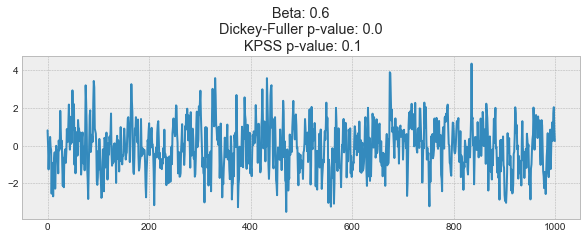

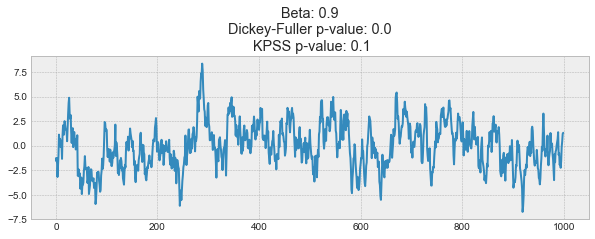

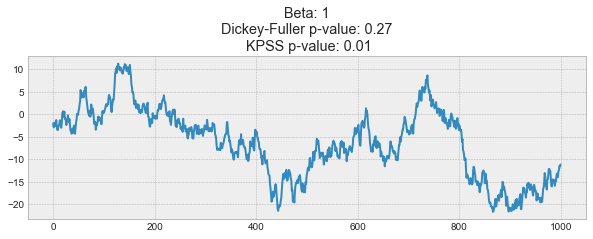

In [13]:
# DF H_0: - не стационарный 
# KPSS H_0: - стационарный 


for beta in [0, 0.6, 0.9, 1]:
    plotProcess(beta=beta)

- На первом графике получился стационарный белый шум, последовательность из независимых нормальных случайных величин с нулевым математическим ожиданием и одинаковой дисперсией.
- На втором значение $\beta$ увеличилось до $0.6$, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. 
- Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. 
- Наконец, значение  равное единице дало процесс случайного блуждания — ряд не стационарен. Для него характеристики зависят от времени и мы подолгу задерживаемся по какую-то конкретную сторону от нуля. 

Нулевая гипотеза теста Дики-Фуллера — ряд не стационарен, отвергалась на первых трех графиках, и не отверглась на последнем. Для KPSS-теста, где нулевая гипотеза заключается в стационарности ряда, мы видим обратную картину. 

Если вычесть из левой и правой части $y_{t-1}$, то получим  $y_t - y_{t-1} = (\beta - 1) y_{t-1} + u_t$, где выражение слева — первые разности. Если $\beta=1$, то первые разности дадут стационарный белый шум $u_t$. Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка. Это записывают как $y_t \sim I(1)$.

Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней). Здравый смысл подсказывает, что больше двух единичных корней не бывает. Так как первая разность - это приросты, а вторая ускорения (по аналогии с производными). Из-за этого в ряды $y_t \sim I(3)$ статистики не верят. 

При этом $y_t \sim I(2)$ ряды в рироде бывают. Один из примеров такого ряда - цены. Первая разность цен это инфляция, а ряд инфляции в теории считается нестационарным, так как может быть выражен через нестационарные процентные ставки. 

# 2. Данные


In [31]:
ads = pd.read_csv('../data/ads.csv', index_col=['Time'], parse_dates=['Time']).asfreq('H')
print(ads.shape)
ads.head()

(216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


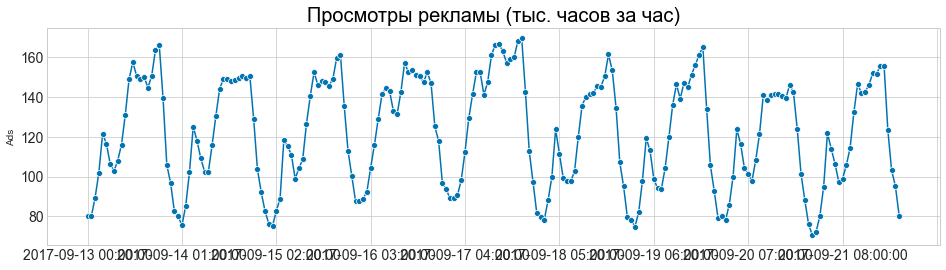

In [32]:
from sktime.utils.plotting import plot_series

y = ads.Ads/10**3  # в тысячах :)

plot_series(y)
plt.title('Просмотры рекламы (тыс. часов за час)', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);

Тесты выдают не только `p_value`, но и расчитанные исследователями-создателями критические значения. У тестов нестандартные распределения. Число лагов для тестирования подбирается автоматически по информационному критерию. 

In [35]:
adfuller(y, regression='c', autolag='AIC')

(-7.089633890638526,
 4.444803688622158e-10,
 9,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 1447.702409531276)

In [37]:
kpss(y, regression='c')

(0.08515879435590198,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Обратите внимание, что тесты можно проводить против разных альтернатив, в зависимости от того, что мы видим в данных: 

```
    * "c" : constant only (default).
    * "ct" : constant and trend.
    * "ctt" : constant, and linear and quadratic trend.
    * "nc" : no constant, no trend.
```

В данном случае мы видим только константу, так как ряд колеблется вокруг ненулевого среднего. Посмотрим на ещё один ряд. 

(300, 1)


<Figure size 1080x432 with 0 Axes>

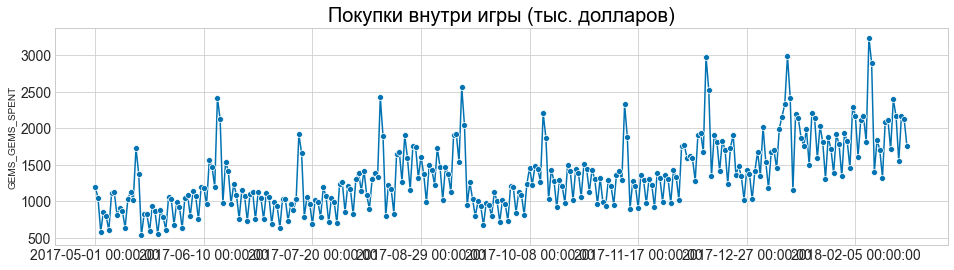

In [38]:
currency = pd.read_csv('../data/currency.csv', index_col=['Time'], parse_dates=['Time'])
print(currency.shape)

plt.figure(figsize=(15, 6))
z = currency.GEMS_GEMS_SPENT/10**3  # в тысячах :)

plot_series(z)
plt.title('Покупки внутри игры (тыс. долларов)', fontsize=20, color='black');
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);

Тут в ряде заметны тренд и константа. Поэтому мы выбираем в качестве базовой другую модель. 

In [40]:
adfuller(y, regression='ct', autolag='AIC')

(-7.2876873847653565,
 3.1289817312819063e-09,
 9,
 206,
 {'1%': -4.003402336644926,
  '5%': -3.4320207442298027,
  '10%': -3.1396965086430555},
 1447.5157288829562)

Видим, что ряд стационарен. Если выбрать неверную спецификацию теста, можно ошибиться с выводами: 

In [41]:
adfuller(y, regression='nc', autolag='AIC')

(-0.6216993344800494,
 0.4455388673196824,
 12,
 203,
 {'1%': -2.5768418078575066,
  '5%': -1.9424010772432776,
  '10%': -1.6155744530123806},
 1482.4285026259213)

# 3. Автоарима

Попробуем оценить на наших данных SARIMA-модель. Делать это будем в рамках [пакета `pmdarima`](https://alkaline-ml.com/pmdarima/user_guide.html)

In [22]:
# !pip install pmdarima

168 48


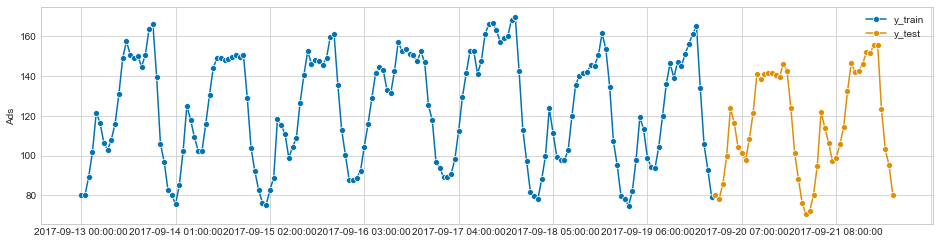

In [42]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

y_train, y_test = temporal_train_test_split(y, test_size=48)
fh = ForecastingHorizon(y_test.index, is_relative=False)

plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [23]:
import pmdarima as pm
from pmdarima import model_selection

arima_model = pm.auto_arima(
    
    y_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5, 
    
    seasonal=True, m=24,
    start_P=0, start_Q=0,
    max_P = 2, max_Q = 2,
    
    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',    
    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
    
    # Можно делать перебор гипер-параметров 
    # на основе метрики на тестовой выборке
    #scoring='mae',
)

 ARIMA(0,0,0)(0,0,0)[24] intercept   : BIC=1600.196, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : BIC=1499.817, Time=0.77 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : BIC=inf, Time=3.84 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : BIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : BIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : BIC=inf, Time=8.36 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : BIC=inf, Time=5.28 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : BIC=inf, Time=5.22 sec
 ARIMA(0,0,0)(2,0,2)[24] intercept   : BIC=inf, Time=6.98 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : BIC=1434.233, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : BIC=1350.698, Time=0.97 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : BIC=1319.072, Time=3.79 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : BIC=1268.214, Time=1.59 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : BIC=1291.260, Time=2.75 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : BIC=inf, Time=13.20 sec
 ARIMA(0,0,1)(2,0,0)[24] intercept

In [43]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                -562.419
Date:                            Tue, 14 Dec 2021   AIC                           1136.838
Time:                                    17:50:10   BIC                           1155.582
Sample:                                         0   HQIC                          1144.445
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9830      0.527      1.864      0.062      -0.051       2.017
ar.L1          0.7903      0.055   

In [44]:
y_pred, pred_ci = arima_model.predict(
    n_periods=48, 
    return_conf_int=True, 
    alpha=0.05
)

mape(y_pred, y_test)

5.158585558908041

In [45]:
df_forecast = pd.DataFrame({'y_pred': y_pred, 'ci_lower': pred_ci[:,0], 'ci_upper': pred_ci[:,1]})
df_forecast.index = fh
df_forecast.head()

,y_pred,ci_lower,ci_upper
2017-09-20 00:00:00,78.126116,65.779989,90.472243
2017-09-20 01:00:00,77.955344,60.126763,95.783925
2017-09-20 02:00:00,85.185536,64.662514,105.708557
2017-09-20 03:00:00,97.442878,75.403301,119.482455
2017-09-20 04:00:00,116.486196,93.550133,139.422258


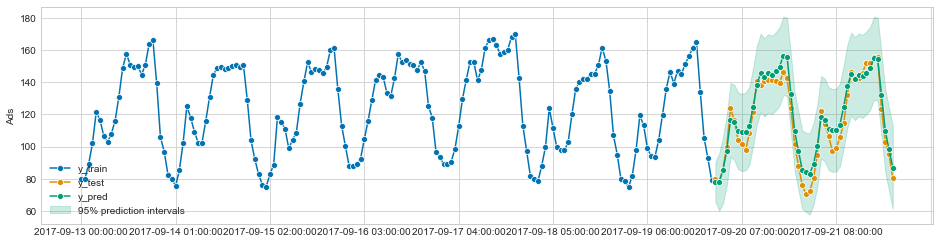

In [46]:
fig, ax = plot_series(y_train, y_test, df_forecast.y_pred, labels=["y_train", "y_test", "y_pred"]);
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');

Посмотрим на графики для диагностики модели. Автокорреляций нет, математическое ожидание равно нулю. Дисперсия постоянна. Распределение остатков нормально. Приятно. 

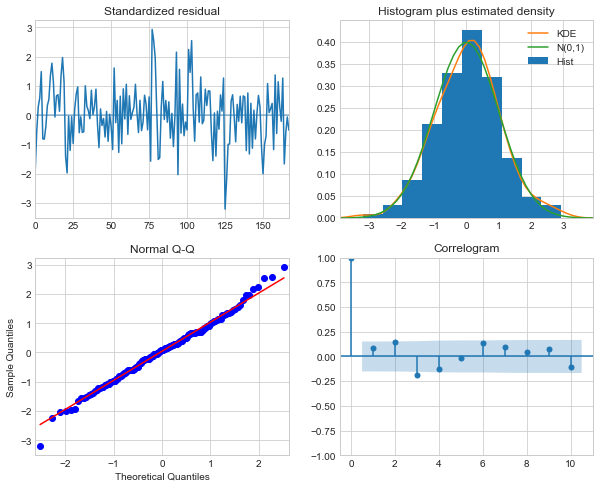

In [28]:
arima_model.plot_diagnostics(figsize=(10, 8));

На самом деле ровно эта же модель вшита в пакет `sktime`, но в урезанном виде. Напомню, что этот пакет только разрабатывается и его великое будущее впереди. 

# 4. Трансформация данных 

В рамках пакета можно делать трансформацию данных и собирать пайплайны также, как и в sklearn. Например, перед обучением модели можно сделать преобразование Бокса-Кокса. Его здесь обычно используют для того, чтобы стабилизировать дисперсию остатков и сделать их нормальными. 

In [47]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

pipeline = Pipeline([
    ("boxcox", BoxCoxEndogTransformer()),
    ("model", pm.AutoARIMA(seasonal=True, suppress_warnings=True))
])

pipeline.fit(y_train)
pipeline.predict(5)

array([ 77.42356287,  83.43529587,  93.37397157, 104.16268234,
       113.81109294])

In [48]:
pipeline.steps[1][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -742.622
Date:                Tue, 14 Dec 2021   AIC                           1493.244
Time:                        17:54:47   BIC                           1505.740
Sample:                             0   HQIC                          1498.315
                                - 168                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     35.3897      7.333      4.826      0.000      21.018      49.762
ar.L1          1.4846      0.068     21.728      0.000       1.351       1.618
ar.L2         -0.6364      0.058    -11.032      0.000      -0.749      -0.523
sigma2       397.9565     49.728      8.003      0.000     300.491     495.422
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                17.85
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.75
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Материалы: 

- [Документация пакета pmdarima с примерами использования](https://alkaline-ml.com/pmdarima/quickstart.html)
- [Гайд по ARIMA от statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)